In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_utils import BasicFunctions, PriceFunctions
from TechnicalAnalysis import TechnicalAnalysis 
from BackTest import Backtester, strategyBacktest
import math
import tensorflow as tf
from scipy.stats import linregress

from IPython.display import HTML

import os
from datetime import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
bf = BasicFunctions()
pf = PriceFunctions()

In [3]:
coins = ['BTC', 'ETH', 'DASH', 'DOGE', 'LTC', 'STR', 'XMR', 'XRP']

In [4]:
dfs = {}
merged_dfs = {}

pd_Xtrains = {}
pd_ytrains = {}
pd_Xtests = {}
pd_ytests = {}

pd_Xtrains_nd = {}
pd_Xtests_nd = {}

means = {}
stds = {}

Xtrains = {}
ytrains = {}
Xtests = {}
ytests = {}


for coin in coins:
    dfs[coin] = pf.get_pandas(coin=coin, targetdays=24, absolute=True)

dfs = pf.to_same_starting(dfs)
dfs = pf.to_usd(dfs)

for coin in coins:
    ta = TechnicalAnalysis(dfs[coin], Timeframe=[24], period=[14], coin=coin)
    ta.merge_time(cache=True)

    merged_dfs[coin] = ta.get_dic()['24hour']
    

for coin in coins:
    pd_Xtrains[coin], pd_ytrains[coin], pd_Xtests[coin], pd_ytests[coin] = pf.split_traintest(merged_dfs[coin])

    pd_Xtrains_nd[coin] = pd_Xtrains[coin].drop('Date', axis=1)
    pd_Xtests_nd[coin] = pd_Xtests[coin].drop('Date', axis=1)

    means[coin], stds[coin], Xtrains[coin], ytrains[coin], Xtests[coin], ytests[coin] = pf.get_numpy(pd_Xtrains_nd[coin], pd_ytrains[coin], pd_Xtests_nd[coin], pd_ytests[coin])

Read from cache
Read from cache
Read from cache
Read from cache
Read from cache
Read from cache
Read from cache
Read from cache


In [5]:
def sigmoid(Z):
    return (1/(1+np.exp(-Z)))

def calculate_accuracy(AL, y):
    #calculate accuracy, precision, recall and F1 value here too
    ALc = AL[:, 0]
    yc = y[:, 0]
    
    ALc = ALc > 0.5
    ALc = ALc.astype(int)
    
    total = ALc.shape[0]
    
    TP = np.sum(np.logical_and(ALc==1, yc==1))
    TN = np.sum(np.logical_and(ALc==0, yc==0))
    
    FP = np.sum(np.logical_and(ALc==1, yc==0))
    FN = np.sum(np.logical_and(ALc==0, yc==1))
    
    P = TP / (TP + FP)
    R = TP / (TP + TN)
    F1 = (2 * P * R) / (P + R)
    
    
    acc = np.sum(ALc == yc)/total
    
    
    print("\nAccuracy: {} \n".format(acc))
    print("True Positive: {} \nTrue Negative: {}\nFalse Positive: {} \nFalse Negative: {}\n".format(TP, TN, FP, FN))
    print("Precision: {} \nRecall: {} \nF1 Score: {}\n".format(P, R, F1))
    
    
    ALcr = AL[:, 1]
    ycr = y[:, 1]

    fig, axes = plt.subplots(figsize=(12,6))
    axes.plot(ALcr, label="Predicted Value")
    axes.plot(ycr, label="Actual Value")
    axes.set_ylabel("Percentage Change")
    axes.set_title("Regression Comparision")
    axes.legend(loc=4)
    
    slope, intercept, rval, pval, stderr = linregress(ycr, ALcr)
    print("R-Value: " + str(rval)) #rvalue is between -1 and 1 and can be used for single. Suitable for my purpose. R2 can be used for multiple, gives one and zero
    
    maximum = max(ycr.max(),AL.max())
    minimum = min(ycr.min(),ALcr.min())
    fig2, ax2 = plt.subplots(figsize=(12,6))
    ax2.scatter(ycr,ALcr)
    ax2.plot([minimum, maximum], [minimum, maximum], 'r-', lw=2)
    
    return AL

In [6]:
def get_best_model(coin, Xval, yval, sessiondir):
    tf.reset_default_graph()
    cwd = os.getcwd()
    
    sessiondir = cwd + '/tf_logs/{}/session-{}.chkp'.format(sessiondir, coin)
    
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(sessiondir + ".meta")
        saver.restore(sess, sessiondir)
        graph = tf.get_default_graph()
        
        Xtensor = graph.get_tensor_by_name("Initialize/X:0")
        training = graph.get_tensor_by_name("Initialize/training:0")
        ALtensor = graph.get_tensor_by_name("ForwardPropagation/Z3/BiasAdd:0") #gotta load this shit somehow
        
        Z = sess.run(ALtensor, feed_dict={Xtensor: Xval, training: False})
        
        Z[:, 0] = sigmoid(Z[:, 0])

        AL = calculate_accuracy(Z, yval)
    
    return AL

INFO:tensorflow:Restoring parameters from C:\Users\User\Desktop\Algo Trading\CryptoTrader\CryptoTrader\CryptoPredictor/tf_logs/session1/session-BTC.chkp

Accuracy: 0.5217391304347826 

True Positive: 331 
True Negative: 77
False Positive: 258 
False Negative: 116

Precision: 0.5619694397283531 
Recall: 0.8112745098039216 
F1 Score: 0.6639919759277834

R-Value: 0.009443636647762568

INFO:tensorflow:Restoring parameters from C:\Users\User\Desktop\Algo Trading\CryptoTrader\CryptoTrader\CryptoPredictor/tf_logs/session1/session-ETH.chkp

Accuracy: 0.4680306905370844 

True Positive: 330 
True Negative: 36
False Positive: 388 
False Negative: 28

Precision: 0.4596100278551532 
Recall: 0.9016393442622951 
F1 Score: 0.6088560885608856

R-Value: -0.006334103331913942

INFO:tensorflow:Restoring parameters from C:\Users\User\Desktop\Algo Trading\CryptoTrader\CryptoTrader\CryptoPredictor/tf_logs/session1/session-DASH.chkp

Accuracy: 0.47058823529411764 

True Positive: 287 
True Negative: 81
False

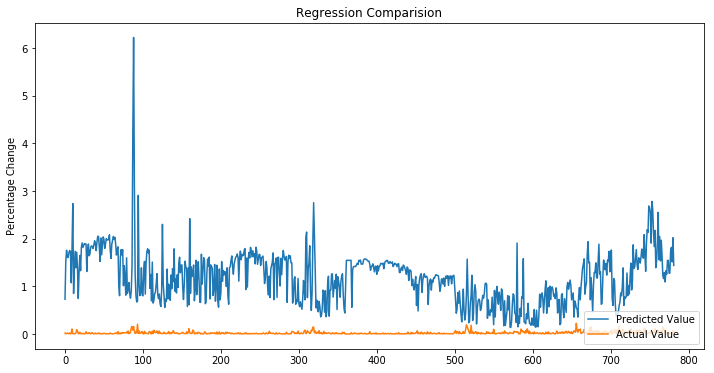

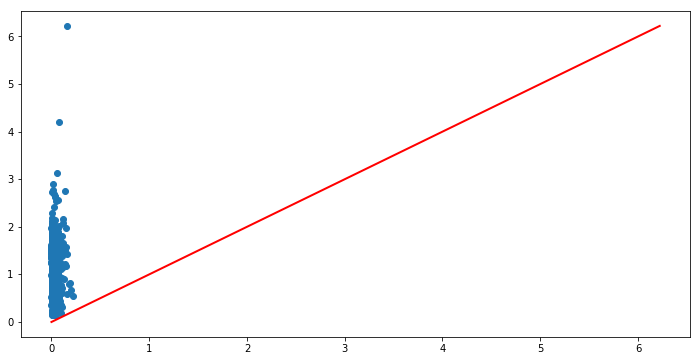

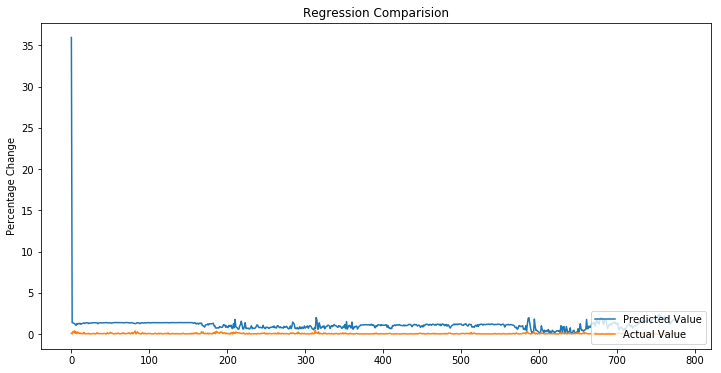

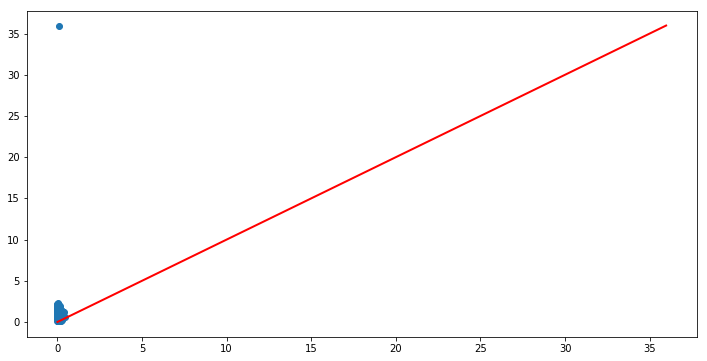

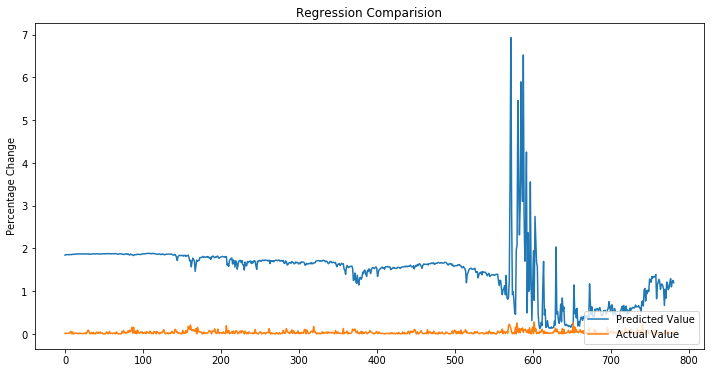

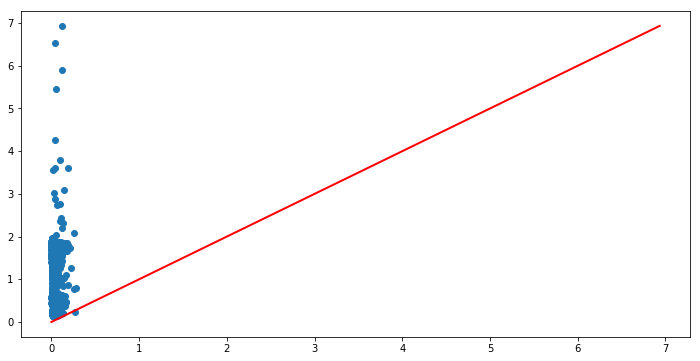

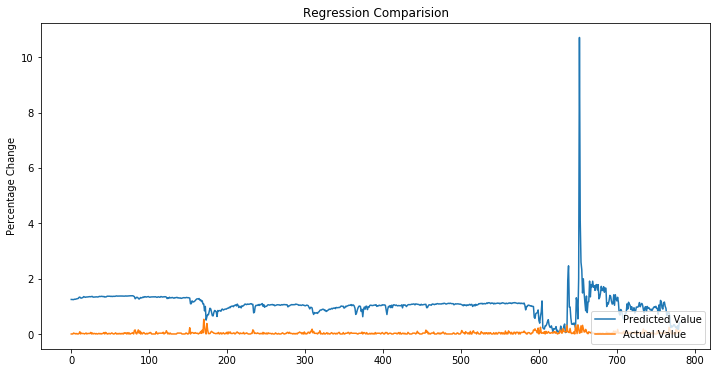

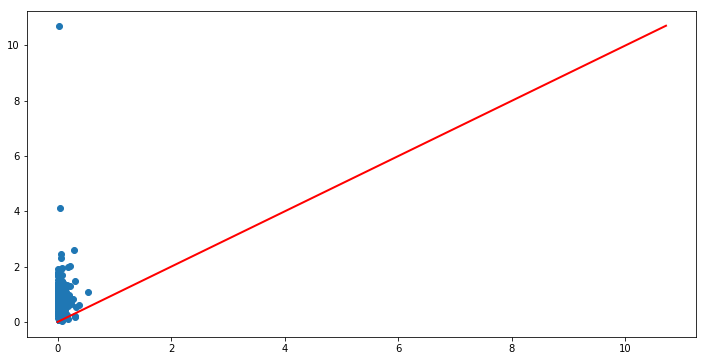

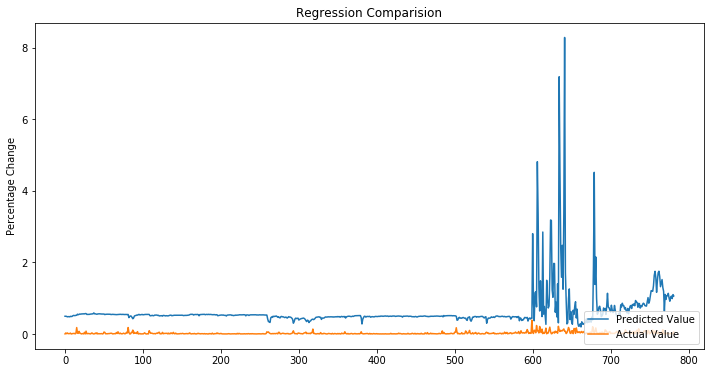

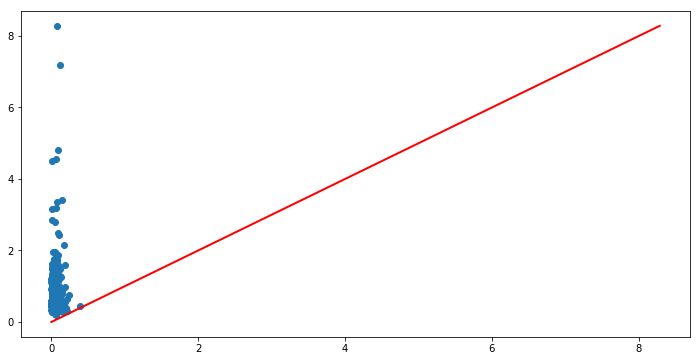

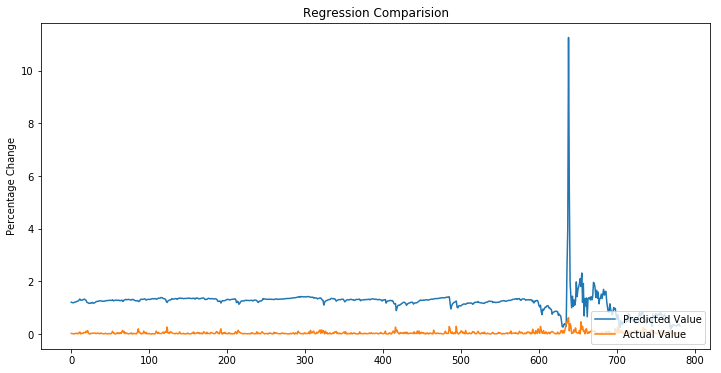

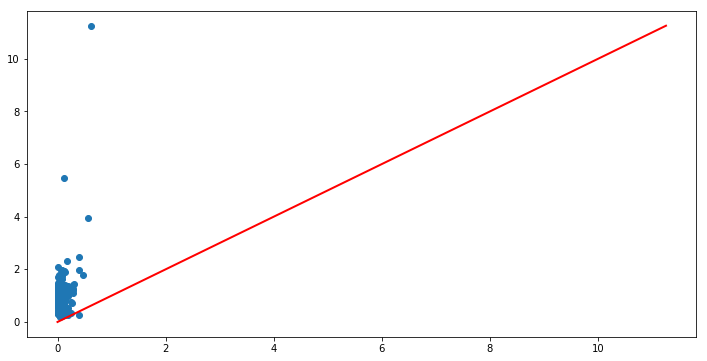

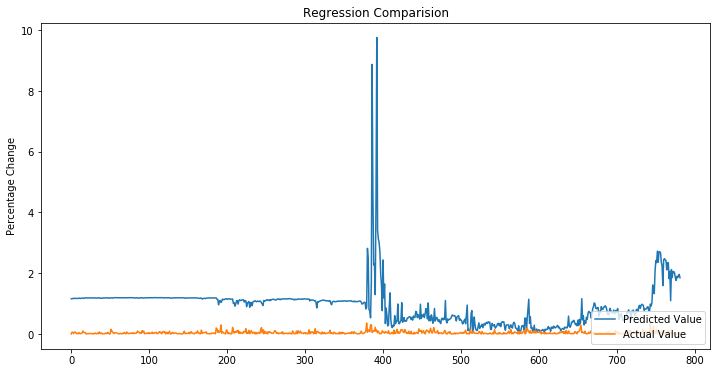

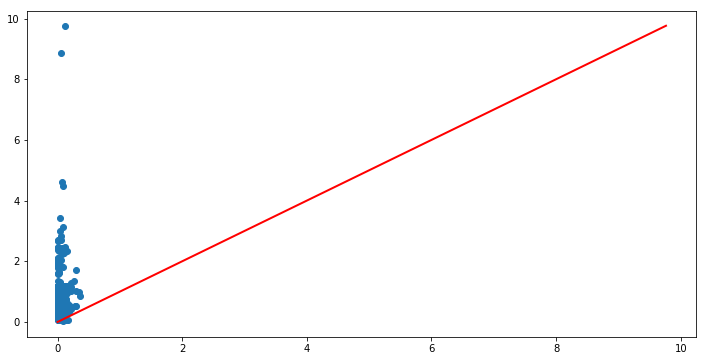

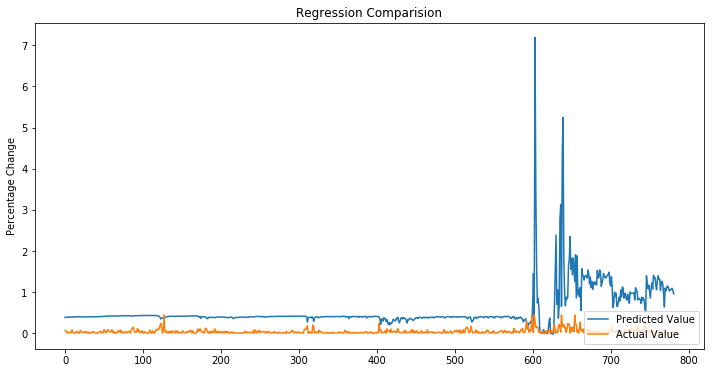

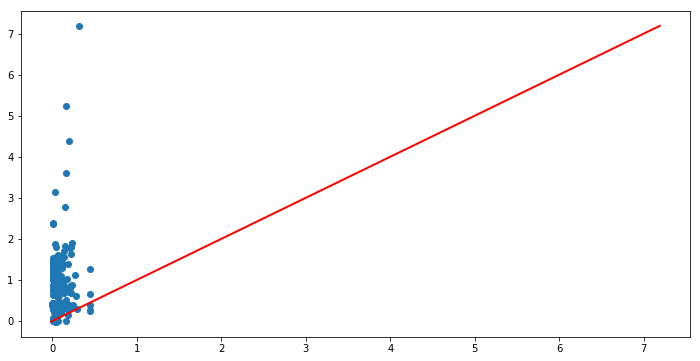

In [7]:
Altrains = {}

for coin in coins:
    Altrains[coin] = get_best_model(coin, Xtrains[coin], ytrains[coin], 'session1')
    print()

INFO:tensorflow:Restoring parameters from C:\Users\User\Desktop\Algo Trading\CryptoTrader\CryptoTrader\CryptoPredictor/tf_logs/session2/session-BTC.chkp

Accuracy: 0.5396419437340153 

True Positive: 347 
True Negative: 75
False Positive: 260 
False Negative: 100

Precision: 0.57166392092257 
Recall: 0.8222748815165877 
F1 Score: 0.67444120505345

R-Value: 0.060180574821480634

INFO:tensorflow:Restoring parameters from C:\Users\User\Desktop\Algo Trading\CryptoTrader\CryptoTrader\CryptoPredictor/tf_logs/session2/session-ETH.chkp

Accuracy: 0.4680306905370844 

True Positive: 338 
True Negative: 28
False Positive: 396 
False Negative: 20

Precision: 0.4604904632152589 
Recall: 0.9234972677595629 
F1 Score: 0.6145454545454545

R-Value: 0.002547017315178484

INFO:tensorflow:Restoring parameters from C:\Users\User\Desktop\Algo Trading\CryptoTrader\CryptoTrader\CryptoPredictor/tf_logs/session2/session-DASH.chkp

Accuracy: 0.47058823529411764 

True Positive: 285 
True Negative: 83
False Posi

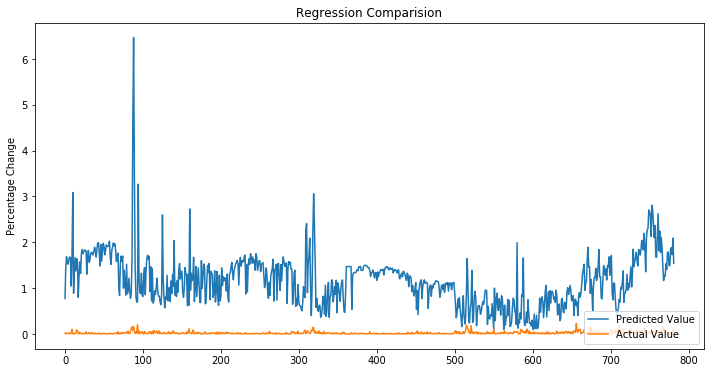

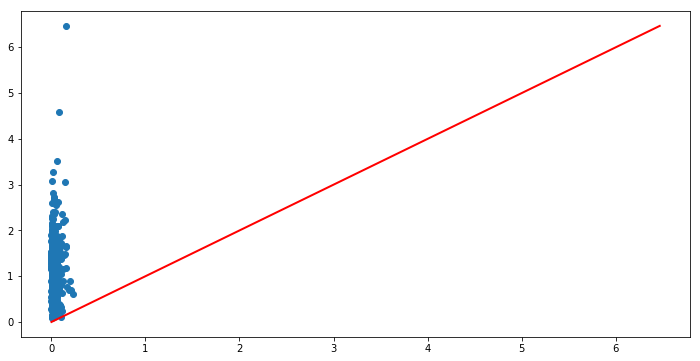

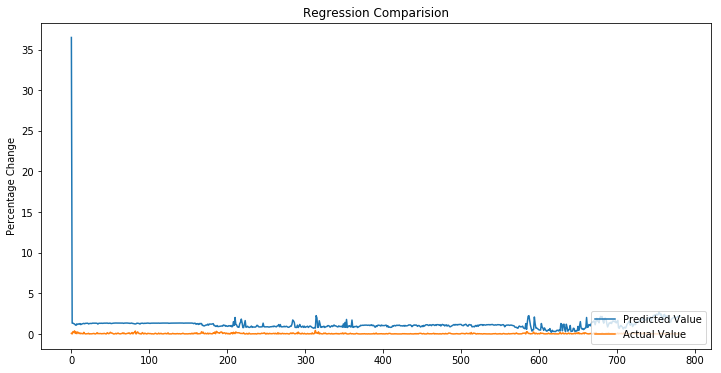

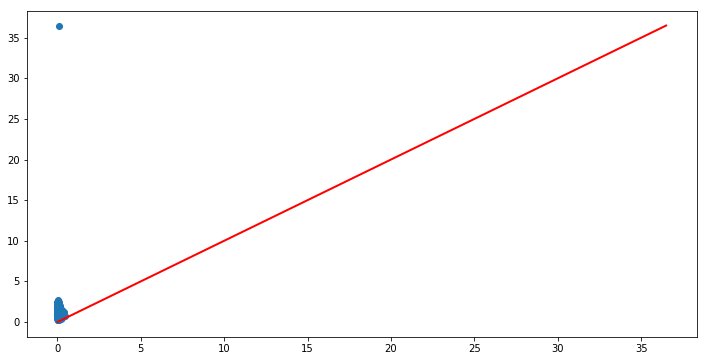

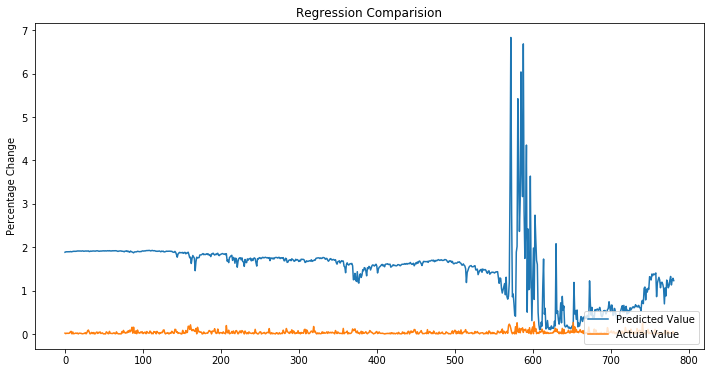

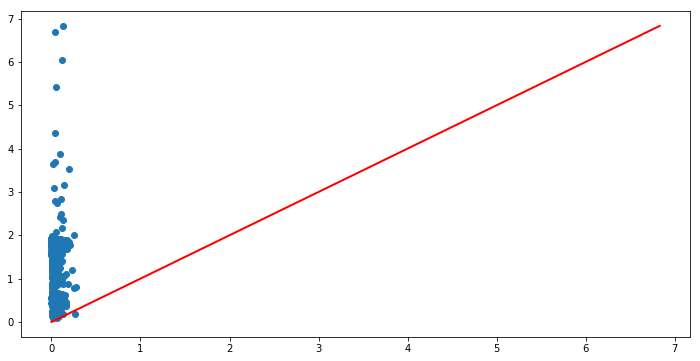

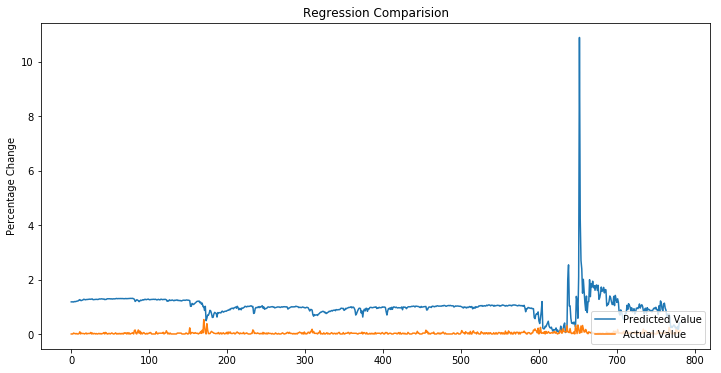

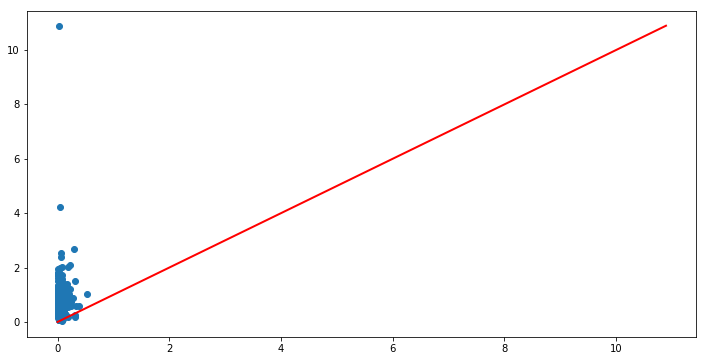

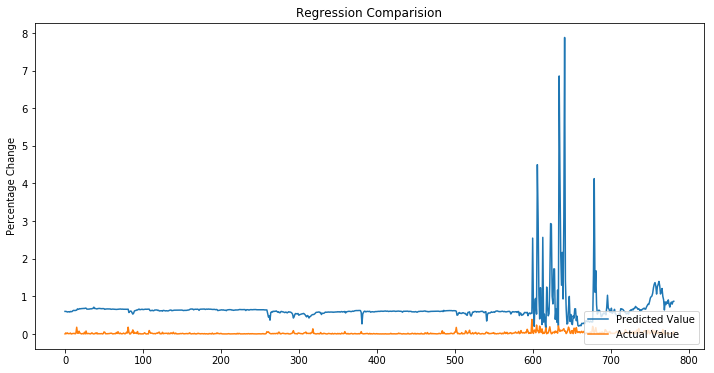

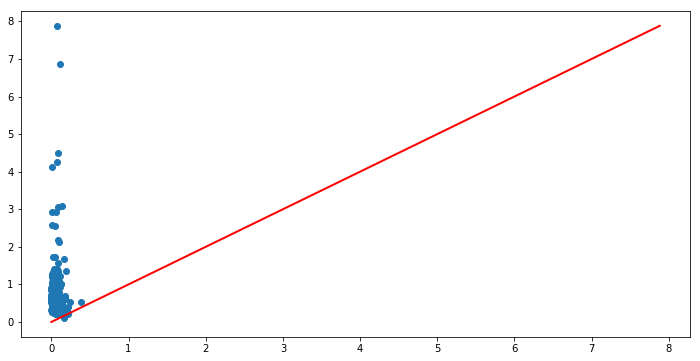

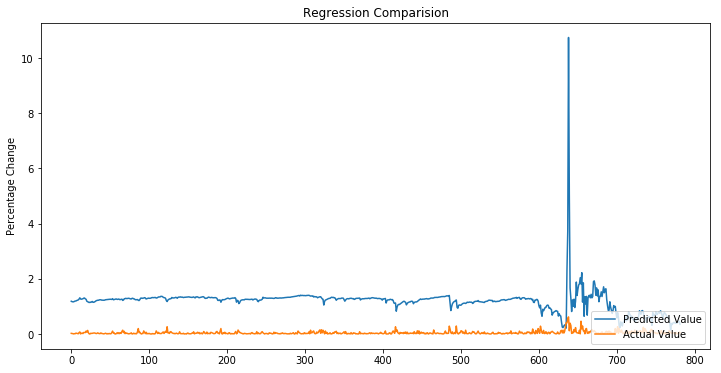

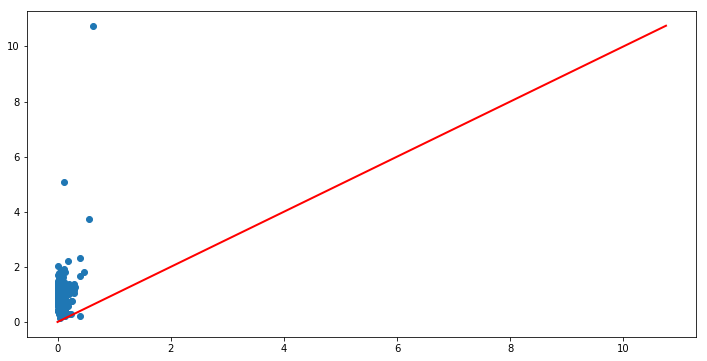

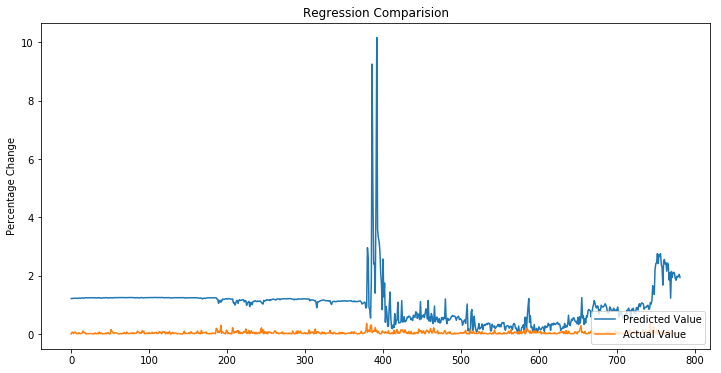

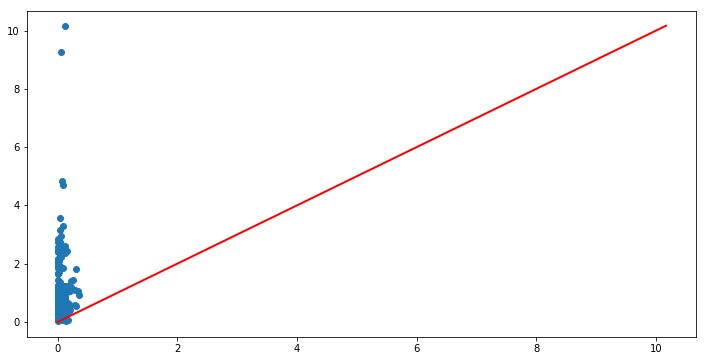

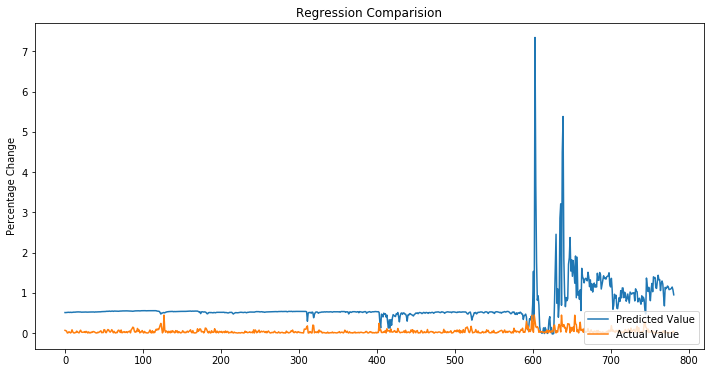

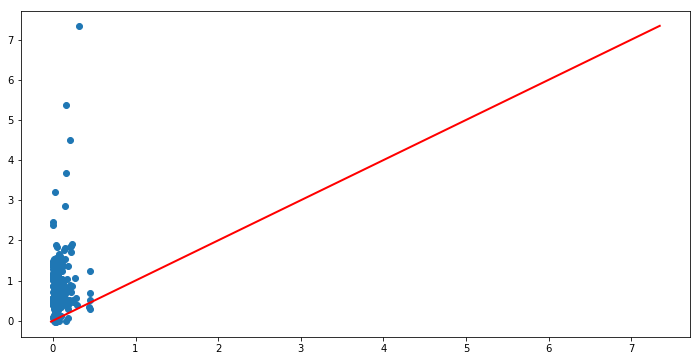

In [10]:
Altrains2 = {}

for coin in coins:
    Altrains2[coin] = get_best_model(coin, Xtrains[coin], ytrains[coin], 'session2')
    print()

In [8]:
def perform_backtest(pd_Xtrains, pd_ytrains, ALtrains):
    
    bars = {}
    
    for key in pd_Xtrains:
        ytrain_temp = pd_ytrains[key].reset_index(drop=True)
        bars[key] = pd.concat([pd_Xtrains[key], ytrain_temp], axis=1)
    

    signals = ALtrains
    
    tbars = {}
    tsignals = {}
    
    tbars['BTC'] = bars['BTC']
    tbars['LTC'] = bars['LTC']
    tbars['ETH'] = bars['ETH']
    tbars['DASH'] = bars['DASH']
    
    tsignals['BTC'] = signals['BTC']
    tsignals['LTC'] = signals['LTC']
    tsignals['ETH'] = signals['ETH']
    tsignals['DASH'] = signals['DASH']
    
    
    bt = Backtester(tbars, tsignals, comission=0.1, maxper=0.01) #bars should contain 
    bt.perform_backtest()
    positions = bt.get_positions()
    bt.get_outcome()
    
    positions = bt.get_positions()
    
    return positions

C:\Users\User\Desktop\Algo Trading\CryptoTrader\CryptoTrader\CryptoPredictor\BackTest\backtester.py:227: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  requiredcoins = closingsignals[self.positions['Coin'] == coin]
C:\Users\User\Desktop\Algo Trading\CryptoTrader\CryptoTrader\CryptoPredictor\BackTest\backtester.py:229: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if(closingsignals[self.positions['Coin'] == coin].shape[0] != 0): #this also happens automatically with the other warning
C:\Users\User\Desktop\Algo Trading\CryptoTrader\CryptoTrader\CryptoPredictor\BackTest\backtester.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  requiredcoins['Amount'] = requiredcoins['Amount'] * -1


Portfolio Stats:
Total Return: 1631.8%
Sharpe Ratio: 3.132 Calmar Ratio: 3.447 Sortino Ratio: 126.331 Maximum Drawdown: -46.79%

BTC Portfolio:
Total Return: 1530.2%
Sharpe Ratio: 2.187 Calmar Ratio: 0.021 Sortino Ratio: 2.678 Maximum Drawdown: -20.1%

LTC Portfolio:
Total Return: 1385.17%
Sharpe Ratio: 1.638 Calmar Ratio: 0.017 Sortino Ratio: 2.636 Maximum Drawdown: -31.04%

ETH Portfolio:
Total Return: 42251.41%
Sharpe Ratio: 2.544 Calmar Ratio: 0.026 Sortino Ratio: 4.559 Maximum Drawdown: -41.33%

DASH Portfolio:
Total Return: 11118.58%
Sharpe Ratio: 2.434 Calmar Ratio: 0.023 Sortino Ratio: 4.471 Maximum Drawdown: -34.6%


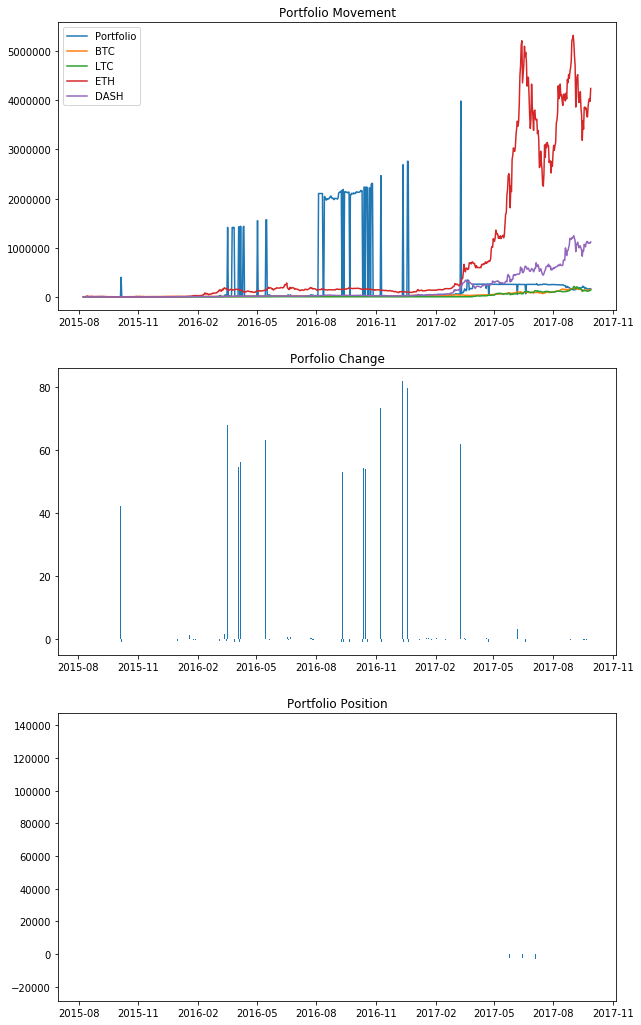

In [9]:
positions = perform_backtest(pd_Xtrains, pd_ytrains, Altrains)

In [11]:
positions

,Date,Coin,Price,Bankroll,Amount,Type,Position,Status
0,2015-08-08 10:45:00,ETH,0.730884,10099.900000,99.900000,OPEN,SHORT,INACTIVE
1,2015-08-09 10:45:00,ETH,0.689262,10005.589158,99.900000,CLOSE,LONG,INACTIVE
2,2015-08-09 10:45:00,DASH,3.095029,9905.689158,99.900000,OPEN,LONG,INACTIVE
3,2015-08-10 10:45:00,DASH,3.082567,9806.788158,98.901000,OPEN,LONG,INACTIVE
4,2015-08-11 10:45:00,DASH,3.178899,9708.886158,97.902000,OPEN,LONG,INACTIVE
5,2015-08-12 10:45:00,DASH,3.059241,9611.983158,96.903000,OPEN,LONG,INACTIVE
6,2015-08-13 10:45:00,DASH,3.083594,9516.079158,95.904000,OPEN,LONG,INACTIVE
7,2015-08-14 10:45:00,DASH,3.058336,9421.174158,94.905000,OPEN,LONG,INACTIVE
8,2015-08-15 10:45:00,DASH,2.940397,9327.268158,93.906000,OPEN,LONG,INACTIVE
9,2015-08-16 10:45:00,DASH,3.113492,9234.361158,92.907000,OPEN,LONG,INACTIVE


C:\Users\User\Desktop\Algo Trading\CryptoTrader\CryptoTrader\CryptoPredictor\BackTest\backtester.py:227: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  requiredcoins = closingsignals[self.positions['Coin'] == coin]
C:\Users\User\Desktop\Algo Trading\CryptoTrader\CryptoTrader\CryptoPredictor\BackTest\backtester.py:229: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if(closingsignals[self.positions['Coin'] == coin].shape[0] != 0): #this also happens automatically with the other warning
C:\Users\User\Desktop\Algo Trading\CryptoTrader\CryptoTrader\CryptoPredictor\BackTest\backtester.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  requiredcoins['Amount'] = requiredcoins['Amount'] * -1


Portfolio Stats:
Total Return: 942.67%
Sharpe Ratio: 4.19 Calmar Ratio: 9.381 Sortino Ratio: 200.889 Maximum Drawdown: -35.97%

BTC Portfolio:
Total Return: 1530.2%
Sharpe Ratio: 2.187 Calmar Ratio: 0.021 Sortino Ratio: 2.678 Maximum Drawdown: -20.1%

LTC Portfolio:
Total Return: 1385.17%
Sharpe Ratio: 1.638 Calmar Ratio: 0.017 Sortino Ratio: 2.636 Maximum Drawdown: -31.04%

ETH Portfolio:
Total Return: 42251.41%
Sharpe Ratio: 2.544 Calmar Ratio: 0.026 Sortino Ratio: 4.559 Maximum Drawdown: -41.33%

DASH Portfolio:
Total Return: 11118.58%
Sharpe Ratio: 2.434 Calmar Ratio: 0.023 Sortino Ratio: 4.471 Maximum Drawdown: -34.6%


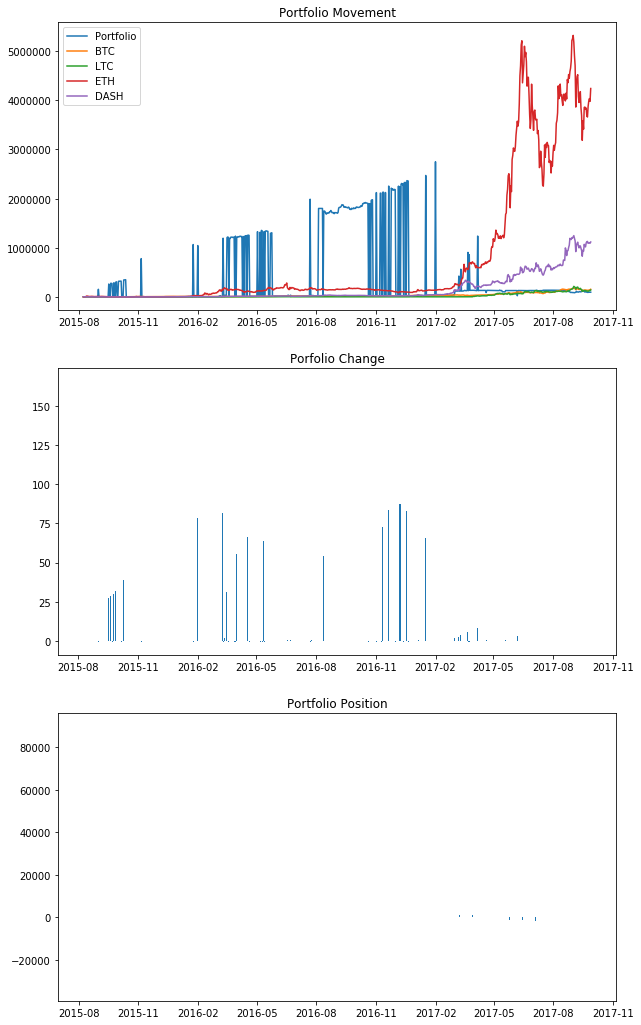

In [13]:
positions2 = perform_backtest(pd_Xtrains, pd_ytrains, Altrains2)

In [14]:
positions2

,Date,Coin,Price,Bankroll,Amount,Type,Position,Status
0,2015-08-08 10:45:00,ETH,0.730884,10099.900000,99.900,OPEN,SHORT,INACTIVE
1,2015-08-09 10:45:00,ETH,0.689262,10005.589158,99.900,CLOSE,LONG,INACTIVE
2,2015-08-09 10:45:00,DASH,3.095029,9905.689158,99.900,OPEN,LONG,INACTIVE
3,2015-08-10 10:45:00,DASH,3.082567,9806.788158,98.901,OPEN,LONG,INACTIVE
4,2015-08-11 10:45:00,DASH,3.178899,9708.886158,97.902,OPEN,LONG,INACTIVE
5,2015-08-12 10:45:00,DASH,3.059241,9611.983158,96.903,OPEN,LONG,INACTIVE
6,2015-08-13 10:45:00,DASH,3.083594,9516.079158,95.904,OPEN,LONG,INACTIVE
7,2015-08-14 10:45:00,DASH,3.058336,9421.174158,94.905,OPEN,LONG,INACTIVE
8,2015-08-15 10:45:00,DASH,2.940397,9327.268158,93.906,OPEN,LONG,INACTIVE
9,2015-08-16 10:45:00,DASH,3.113492,9234.361158,92.907,OPEN,LONG,INACTIVE
